# Pilot Dataset: Richmond Hill, Queens

This notebook applies the methods outlined in previous notebooks to produce a pilot dataset at the neighborhood level for the study neighborhood of Richmond Hill, Queens.

## Data Sources

| Capture Date | Dataset | Owner | Source | Layer |
| :--- | :--- | :--- | :--- | :--- |
| 2017 | LiDAR Point Cloud | DOITT | [link](ftp://ftp.gis.ny.gov/elevation/LIDAR/NYC_TopoBathymetric2017) | `pointcloud` |
| 2017 | LiDAR-derived DEM | DOITT | [link](ftp://ftp.gis.ny.gov/elevation/DEM/NYC_TopoBathymetric2017) | `dem` |
| 2017 | LiDAR-derived DSM | DOITT | [link](ftp://ftp.gis.ny.gov/elevation/DEM/NYC_TopoBathymetric2017_DSM) | `dsm` |
| 2018 | Aerial Orthoimagery | DOITT | [link](https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_AerialImagery.md) | `orthoimagery` |
| 2021? | Building Footprints | DOITT/DOF | [link](https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh) | `buildingfootprints` |
| 2021 | MapPLUTO | DCP | [link](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page) | - |
| 2021 | Neighborhood Tabulation Areas | DCP | [link](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page) | - |

The sources listed above are loaded into a PostGIS database (with PostGIS [raster extensions](https://postgis.net/docs/RT_FAQ.html) and [pgpointcloud](https://github.com/pgpointcloud/pointcloud) enabled). Most of the methods below rely on geoprocessing operations accomplished through database queries.

## Introduction

Space-based remotely-sensed datasets like those produced through the [Shuttle Radar Topography Mission](https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission) and [Landsat Program](https://en.wikipedia.org/wiki/Landsat_program) are usually not of a high enough spatial resolution to be useful for building-scale studies. Here's what a 30m grid looks like superimposed on a typical NYC row house:
![](assets/resolution-30m.png)

Airborne [LiDAR](https://en.wikipedia.org/wiki/Lidar) surveys are a relatively affordable "ground-based" alternative that combine urban or regional scale coverage with extremely high spatial resolution. Here's the same building as above shown in transparent blue with a LiDAR point cloud and 30m grid cell superimposed:
![](assets/resolution-pointcloud.png)

This combination of wide coverage and high resolution translates to an extremely large dataset. Because of the challenges associated with efficiently storing, querying and processing something of this size, and the additional challenge of accounting for a third spatial dimension, LiDAR datasets are commonly used to create derivative raster imagery in the form of Digital Elevation Models (DEM) which represent the surface of the ground, or Digital Surface Models (DSM) which represent the highest points in the capture as a continuous surface. In the case of the NYC LiDAR dataset, these are provided at a 1ft spatial resolution, which provides ample opportunity to answer basic questions about the size and shape of urban roofs. Here's our building again, shown with a 100x100ft grid (about 30x30m) of 1ft cells:
![](assets/resolution-1ft.png)

And here's what that looks like in context. This shows a single block of the DSM in Brooklyn with building footprints superimposed. Darker cells represent higher elevations. Notice the substantial noise near roof edges:
![](assets/resolution-map.png)

Like all raster and raster-like spatial data, LiDAR datasets have no intrinsic meaning. Information must be extracted or inferred with the help of vector datasets and spatial analysis algorithms.

## Setup

This step imports Python libraries needed to run the notebook, sets up a connection to the database and uses it to load a group of building footprints that we'll use as the basis of the per-building roofs dataset.

In [1]:
import os
from colorsys import rgb_to_hls

import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# import psycopg2
# from rasterio.io import MemoryFile
# import numpy as np

In [2]:
# set up database connection
load_dotenv(".env")
conn_vars = ['PG_USER', 'PG_PASS', 'PG_HOST', 'PG_PORT', 'PG_DB']
user, password, host, port, dbname = [os.getenv(var) for var in conn_vars]
connection_string = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

engine = create_engine(connection_string)
conn = engine.raw_connection()
cursor = conn.cursor()

<AxesSubplot:>

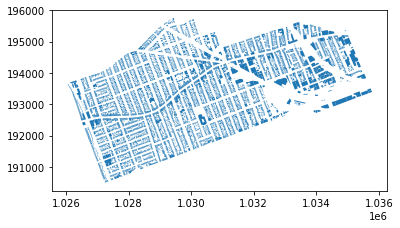

In [3]:
# fetch building footprints
bounds_wkt = 'MultiPolygon (((1035136 195251.4, 1035205.4 195059.3, 1035233.6 194981.4, 1035263.1 194899.8, 1035381.8 194571.6, 1035395.5 194531.9, 1035411.5 194486.3, 1035411.9 194485.1, 1035420.4 194460.8, 1035486.1 194297.2, 1035529.6 194188.9, 1035548.8 194143, 1035610.4 193995.8, 1035617.9 193977.7, 1035687.1 193812.3, 1035711.2 193753.3, 1035757.9 193644.9, 1035779.6 193587.6, 1035814.5 193509.7, 1035879.8 193363.4, 1035891.1 193339.5, 1035902.4 193315.4, 1035848.4 193311.4, 1035815.3 193312.6, 1035782.1 193310, 1035749.3 193303.7, 1035717.6 193293.9, 1035461.2 193198, 1035223 193105.7, 1034991.6 193019.8, 1034758.6 192931.2, 1034473.9 192823.7, 1034426.5 192810.5, 1034377.8 192802.1, 1034328.5 192798.6, 1034279.3 192800.1, 1034181.2 192755.1, 1033925 192663.3, 1033863.9 192818.2, 1033379.3 192636.4, 1033116.9 192537.9, 1032836.7 192429.2, 1032575.9 192339.3, 1032560.9 192334.6, 1032548.3 192330.6, 1032519.3 192322.6, 1032249.5 192247.7, 1031954.9 192158.6, 1031719.3 192074.7, 1031482.1 191992.9, 1031256 191905.4, 1031032.1 191812.1, 1030797.4 191727.8, 1030567.5 191641.8, 1030323.9 191552.7, 1030063 191452.8, 1029793.2 191353.2, 1029556 191263.8, 1029312.6 191175.3, 1029069.6 191081.9, 1028990.6 191053, 1028827.1 190986, 1028333.5 190803.7, 1027852.7 190624.7, 1027471 190479.4, 1027438.3 190468.3, 1027246.5 190395, 1027234 190424.6, 1027223.8 190451.9, 1026965.9 191124.4, 1026784.7 191608.4, 1026473.9 192438.5, 1026137.2 193451.3, 1025988.1 193683.9, 1026082.1 193715.7, 1026208.8 193780, 1026339.6 193802, 1026426.2 193832, 1026673.6 193914.4, 1027222.1 194110, 1027430.1 194263.8, 1027618.3 194406.8, 1027799.9 194546.4, 1027850.1 194584.1, 1027850.1 194584.1, 1027850.2 194584.1, 1027903.1 194618, 1027903.1 194618.1, 1027903.2 194618.1, 1027958.5 194647.9, 1027958.5 194648, 1027958.6 194648, 1028015.8 194673.6, 1028180.6 194746, 1028757.8 195326.2, 1029010.8 195547.8, 1029454.3 195882.1, 1029550.1 195593.6, 1029569.3 195598.6, 1029588.9 195601.2, 1029608.7 195601.1, 1029628.3 195598.5, 1029644.7 195593.9, 1029661.5 195591, 1029678.4 195590.1, 1029695.4 195591, 1029712.2 195593.8, 1029728.5 195598.4, 1029744.3 195604.7, 1029759.2 195612.8, 1029773.2 195622.5, 1029786 195633.6, 1029797.5 195646.1, 1029807.6 195659.8, 1029815.1 195668.7, 1029823.5 195676.7, 1029832.9 195683.5, 1029843 195689.2, 1029853.8 195693.6, 1029865 195696.6, 1030066.7 195764.7, 1030108.8 195779.5, 1030300 195204.2, 1030429.4 195246.8, 1030548.3 195285.9, 1030794.6 195367.9, 1030965 194856.5, 1031212.1 194939.7, 1031459.1 195021.7, 1031533.5 195047.3, 1031705.7 195104.3, 1031953.6 195186.5, 1032199.5 195269, 1032474.9 195363.2, 1032723.2 195443.7, 1032974.2 195527.1, 1033084.8 195564.8, 1033218.2 195609.2, 1033406.9 195675.7, 1033476 195687, 1033748.1 195600.2, 1034009.5 195532.1, 1034839.6 195326.2, 1034845.1 195325.5, 1034850.7 195325.7, 1034856.2 195326.8, 1034861.5 195328.8, 1034866.4 195331.6, 1034870.8 195335.1, 1034874.5 195339.2, 1034877.6 195343.9, 1034879.9 195349, 1034881.4 195354.5, 1034897.7 195435.8, 1035029.2 195249, 1035136 195251.4)))'

query = f'''
SELECT
  bin,
  modified,
  geometry as geom
FROM
  buildingfootprints
WHERE
  ST_Intersects(
    geometry,
    ST_GeomFromText(
      '{bounds_wkt}',
      2263
    )
  )
;
'''

buildings = gpd.GeoDataFrame.from_postgis(query, engine)
buildings.plot()

In [4]:
# uncomment to use smaller subset for testing
buildings = buildings.head(20)

In [22]:
buildings

,bin,modified,geom,roof_slope_avg,roof_slope_class,roof_color,cool_roof_status
0,4576731,2017-08-17,"MULTIPOLYGON (((1029971.700 192307.550, 102995...",12.177371,PITCHED,"(0.4748196562575648, 0.4857032195594287, 0.502...",False
1,4196264,2017-08-22,"MULTIPOLYGON (((1033359.992 194504.247, 103332...",2.352665,FLAT,"(0.8696876758905085, 0.8961691765165352, 0.907...",True
2,4438599,2017-08-22,"MULTIPOLYGON (((1031835.513 192365.696, 103177...",12.766336,PITCHED,"(0.20620251484688631, 0.22916014865211595, 0.2...",False
3,4191662,2017-08-22,"MULTIPOLYGON (((1027683.710 192775.850, 102763...",39.043612,PITCHED,"(0.2334220412516057, 0.30042414988244986, 0.36...",False
4,4496464,2017-08-17,"MULTIPOLYGON (((1029748.230 193281.390, 102972...",56.047395,HIGHPITCH,"(0.6439538638985006, 0.6438858131487889, 0.627...",False
5,4194845,2017-08-22,"MULTIPOLYGON (((1029731.130 192959.480, 102973...",34.433317,PITCHED,"(0.5859388534530278, 0.494281045751634, 0.4319...",False
6,4194126,2017-08-22,"MULTIPOLYGON (((1027159.677 191885.711, 102715...",9.410030,FLAT,"(0.7558205115519715, 0.7812587608634707, 0.792...",False
7,4196321,2017-08-22,"MULTIPOLYGON (((1034194.510 194525.368, 103418...",2.613883,FLAT,"(0.8417564505018955, 0.8699982647926428, 0.886...",True
8,4195583,2017-08-22,"MULTIPOLYGON (((1030115.519 191975.156, 103007...",39.626310,PITCHED,"(0.6112617330803289, 0.6645768500948767, 0.686...",False
9,4196379,2017-08-22,"MULTIPOLYGON (((1034405.250 195080.431, 103433...",5.282350,FLAT,"(0.6372953594987592, 0.6702970425739356, 0.683...",False


## Slope

Here we just average the result of PostGIS's `ST_Slope` applied to the DEM (clipped to each building footprint) (Kouhestani 2019). The `classify_slope` function defined below sets cutoff thresholds for three classes of roof, `PITCHED`, `FLAT` and `HIGHPITCH`, based on language in Local Laws 92 and 94 of 2019 and solar installation guidelines provided by MOCS.

In [5]:
slope_query_template = '''
SELECT 
  (ST_SummaryStats(
      ST_Slope(
        ST_Clip(
          s.rast,
          1,
          ST_Buffer(
            f.geometry,
            -3
          ),
          400,
          TRUE
        )
      ),
      TRUE
  )).mean
FROM 
  dsm s,
  buildingfootprints f
WHERE
  f.bin = '{bldg_id}'
  AND
  ST_Intersects(
    s.rast,
    f.geometry
  )
;
'''


def slope_by_bldg_id(bldg_id):
  q = slope_query_template.format(bldg_id=bldg_id)
  cursor.execute(q)
  mean_slope = cursor.fetchone()[0]
  return mean_slope

# based on LL92/94 thresholds, solar industry practices
# as described in EK email 2021-08-12
def classify_slope(slope_deg):
  if 0 <= slope_deg <= 9.46: # under 2:12 pitch
    return 'FLAT'
  elif slope_deg <= 45.00: # under 12:12 pitch
    return 'PITCHED'
  elif slope_deg < 90: # under vertical
    return 'HIGHPITCH'

In [6]:
buildings['roof_slope_avg'] = buildings['bin'].apply(slope_by_bldg_id)
buildings['roof_slope_class'] = buildings['roof_slope_avg'].apply(classify_slope)

/usr/local/Caskroom/miniconda/base/envs/gis/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


## Segmentation

We can use `ST_Aspect` in combination with `ST_Reclass` to categorize individual roof pixels by cardinal direction. Dissolving via `ST_DumpAsPolygons` can give approximate boundaries of individual roof faces, which we can use to establish counts and rough area estimates, although the buffer we apply to filter out edge noise interferes with the accuracy of these numbers.

The total roof area is the same as the building footprint when using these methods.

In [7]:
# example showing reclass
# query = '''
# SELECT
#   ST_AsGDALRaster(
#     ST_Reclass(
#       ST_Aspect(
#         ST_Clip(
#           s.rast,
#           1,
#           ST_Buffer(
#             f.geometry,
#             -3
#           ),
#           90,
#           TRUE
#         )
#       ),
#       '-1:0, 0-45:1, 46-90:2, 91-135:3, 136-180:4, 181-225:5, 226-270:6, 271-315:7, 316-360:8',
#       '4BUI'
#     ),
# 'GTiff')
# FROM
#   dsm s,
#   buildingfootprints f
# WHERE
#   ST_Intersects(s.rast, f.geometry)
# AND
#   f.bin = '3008070'
# ;
# '''

# rast = preview_raster(cursor, query)

## Roof Shading

GRASS contains tools for solar analysis that can be used to get raster representations of cumulative insolation time for individual roofs ([`r.sun`](https://grass.osgeo.org/grass78/manuals/r.sun.html)). Zonal statistics can applied to the raster can then give the average insolation time per building or per roof segment. (Hofierka 2002)

Unfortunately it's a bit weird to set up since it doesn't exist as a standalone Python library and there is no conda package (see [this discussion](https://github.com/conda-forge/staged-recipes/issues/2562)). If you have QGIS installed (on Linux or Mac) you can use the GRASS binaries included with the installation alongside the `grass-session` module from pip. More details are available [here](https://neteler.gitlab.io/grass-gis-analysis/05_grass_gis_python_session/).

In [8]:
# set environment variables needed by GRASS
# os.environ['GRASSBIN'] = '/Applications/QGIS.app/Contents/Resources/grass78/grass'

In [9]:
# from grass_session import Session as grass_session
# import grass.script
# from grass.pygrass.modules.shortcuts import raster as r

In [10]:
# create GRASS session
# gs = grass_session()

In [11]:
# define function using grass to get average insolation time per roof
#gs.open()
# r.sun()

In [12]:
# close session when done
# gs.close()

## Materials

To determine (or guess) the surface materials of individual rooftops, we can use a supervised classification approach similar to what can be done with the Image Classification tool in ArcMap (Spatial Analyst).

See this [article](https://towardsdatascience.com/object-based-land-cover-classification-with-python-cbe54e9c9e24) on how to do this with [skimage](https://scikit-image.org/)

To determine roof materials and their properties (namely reflectance/albedo), we can use aerial orthoimagery and intensity values from the LiDAR point cloud, clipped to individual building footprints. The required data is available in the NYC Digital Twin.

**Albedo** as a material property can be approximated once materials are known.

In [13]:
# plot config
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (8,8)

In [14]:
# conn = psycopg2.connect(conn_string)
# cursor = conn.cursor()

# def preview_raster(cursor, query):
#     cursor.execute(query)
    
#     for row in cursor:
#         rast = row[0].tobytes()
#         with MemoryFile(rast).open() as result:
#             result_file = result
#             result_raster = result.read(1) # argument is 1-indexed band of the raster
    
#     plt.imshow(result_raster, cmap='spring')
#     return result_raster

In [15]:
# if not already enabled:
# cursor.execute("SET postgis.gdal_enabled_drivers TO 'GTiff';")

In [16]:
# aoi = 'Polygon ((984787.38108399 186239.23170573, 985227.65583923 186082.77871753, 985124.35675087 185810.99179573, 984689.09651449 185971.45639901, 984787.38108399 186239.23170573))'

# query = '''
# SELECT 
#   ST_AsGDALRaster(
#       ST_Aspect(ST_Union(rast)),
#       'GTiff'
#   )
# FROM 
#   dsm
# WHERE
#   ST_Intersects(
#     rast,
#     ST_GeomFromText(
#       '{}',
#       2263
#     )
#   )
# ;
# '''

# query = query.format(aoi)
# # print(query)

# preview_raster(cursor, query)

In [21]:
buildings

,bin,modified,geom,roof_slope_avg,roof_slope_class,roof_color,cool_roof_status
0,4576731,2017-08-17,"MULTIPOLYGON (((1029971.700 192307.550, 102995...",12.177371,PITCHED,"(0.4748196562575648, 0.4857032195594287, 0.502...",False
1,4196264,2017-08-22,"MULTIPOLYGON (((1033359.992 194504.247, 103332...",2.352665,FLAT,"(0.8696876758905085, 0.8961691765165352, 0.907...",True
2,4438599,2017-08-22,"MULTIPOLYGON (((1031835.513 192365.696, 103177...",12.766336,PITCHED,"(0.20620251484688631, 0.22916014865211595, 0.2...",False
3,4191662,2017-08-22,"MULTIPOLYGON (((1027683.710 192775.850, 102763...",39.043612,PITCHED,"(0.2334220412516057, 0.30042414988244986, 0.36...",False
4,4496464,2017-08-17,"MULTIPOLYGON (((1029748.230 193281.390, 102972...",56.047395,HIGHPITCH,"(0.6439538638985006, 0.6438858131487889, 0.627...",False
5,4194845,2017-08-22,"MULTIPOLYGON (((1029731.130 192959.480, 102973...",34.433317,PITCHED,"(0.5859388534530278, 0.494281045751634, 0.4319...",False
6,4194126,2017-08-22,"MULTIPOLYGON (((1027159.677 191885.711, 102715...",9.410030,FLAT,"(0.7558205115519715, 0.7812587608634707, 0.792...",False
7,4196321,2017-08-22,"MULTIPOLYGON (((1034194.510 194525.368, 103418...",2.613883,FLAT,"(0.8417564505018955, 0.8699982647926428, 0.886...",True
8,4195583,2017-08-22,"MULTIPOLYGON (((1030115.519 191975.156, 103007...",39.626310,PITCHED,"(0.6112617330803289, 0.6645768500948767, 0.686...",False
9,4196379,2017-08-22,"MULTIPOLYGON (((1034405.250 195080.431, 103433...",5.282350,FLAT,"(0.6372953594987592, 0.6702970425739356, 0.683...",False


## Cool Roof Status

Whether or not a building has a cool roof treatment is a more straightforward question than albedo in its pure sense. Here we can simply assign a threshold to the average brightness of the roof which can generally provide a reliable proxy for whether or not a cool roof can be installed (exceptions?). Additional variables in the query may improve accuracy, but validation and further study are needed.

In [17]:
color_query_template = '''
SELECT
  (ST_SummaryStats(cropped.rast, 1)).mean / 255 as R,
  (ST_SummaryStats(cropped.rast, 2)).mean / 255 as G,
  (ST_SummaryStats(cropped.rast, 3)).mean / 255 as B
FROM (
  SELECT
    ST_Clip(
      ST_Union(s.rast),
      f.geometry,
      TRUE
    ) as rast
  FROM
    orthoimagery s,
    buildingfootprints f
  WHERE
    ST_Intersects(
      s.rast,
      f.geometry
    )
  AND
    f.bin = '{bldg_id}'
  GROUP BY
    f.geometry
) AS cropped
;
'''


def color_by_bldg_id(bldg_id):
  q = color_query_template.format(bldg_id=bldg_id)
  cursor.execute(q)
  return cursor.fetchone()


def classify_coolroof(record):
  lightness = rgb_to_hls(*record)[1]
  # if color is past a certain brightness...
  threshold = 0.80
  if 0 <= lightness <= threshold:
    return False
  else:
    return True


In [18]:
buildings['roof_color'] = buildings['bin'].apply(color_by_bldg_id)
buildings['cool_roof_status'] = buildings['roof_color'].apply(classify_coolroof)

## Installations and Obstacles (2D)

Supervised classification methods can be used to identify certain rooftop objects/obstructions from orthoimagery. Machine learning methods can potentially be used to classify/categorize objects with greater accuracy. See National University of Singapore's [Roofpedia](https://ual.sg/project/roofpedia/). (Wu 2021)

## Installations and Obstacles (3D)

A more computationally intensive approach involves querying the original pointcloud dataset on a per-building basis and applying point cloud segmentation methods to detect individual objects. (Vosselman 2017)

## Difference with 3D Buildings

How many of the footprints used for the base dataset differ from the buildings included in the [2014 3D Building Model](https://www1.nyc.gov/site/doitt/initiatives/3d-building.page)?

## Research Questions

What are impacts of changes to roof regulations such as the Fire Code, Building Codes and Zoning Resolution provisions (which have different requirements for low-slope vs steep roofs)?

How much roof area is available for technologies such as solar, cool roofs, green roofs,  or batteries? Where/which building types?

What neighborhoods/building types  currently have the most/least solar, cool roofs, green roofs, etc.?

## Export

In [19]:
# adjust field types for eventual export
buildings['modified'] = buildings['modified'].astype('str')

In [20]:
buildings.to_file('/Users/carsten/Desktop/roofs.shp')

<ipython-input-20-bf97cc7475dd>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  buildings.to_file('/Users/carsten/Desktop/roofs.shp')


ValueError: Invalid field type <class 'tuple'>

## References

Ban-Weiss, George, Jordan Woods, and Ronnen Levinson. “Using Remote Sensing to Quantify Albedo of Roofs in Seven California Cities: Final Report to California Air Resources Board.” Berkeley, CA: Environmental Energy Technologies Division, Lawrence Berkeley National Laboratory, March 2014.
Hofierka, Jaroslav, and Marcel Šúri. “The Solar Radiation Model for Open Source GIS: Implementation and Applications,” 2002, 19.

Joerg, Philip C., Jörg Weyermann, Felix Morsdorf, Michael Zemp, and Michael E. Schaepman. “Computation of a Distributed Glacier Surface Albedo Proxy Using Airborne Laser Scanning Intensity Data and In-Situ Spectro-Radiometric Measurements.” Remote Sensing of Environment 160 (April 1, 2015): 31–42.

Mansouri Kouhestani, Fariborz, James Byrne, Dan Johnson, Locke Spencer, Paul Hazendonk, and Bryson Brown. “Evaluating Solar Energy Technical and Economic Potential on Rooftops in an Urban Setting: The City of Lethbridge, Canada.” International Journal of Energy and Environmental Engineering 10, no. 1 (March 2019): 13–32.

Quantum Spatial. “New York City, New York Topobathymetric LiDAR Technical Data Report,” August 3, 2018.

Vosselman, George, Max Coenen, and Franz Rottensteiner. “Contextual Segment-Based Classification of Airborne Laser Scanner Data.” ISPRS Journal of Photogrammetry and Remote Sensing 128 (June 1, 2017): 354–71. 

Wu, Abraham Noah, and Filip Biljecki. “Roofpedia: Automatic Mapping of Green and Solar Roofs for an Open Roofscape Registry and Evaluation of Urban Sustainability.” Landscape and Urban Planning 214 (October 1, 2021): 104167.  


## Checklist

- [x] introduction
- [x] slope
- [ ] segmentation
- [ ] roof shading
- [ ] albedo
- [x] cool roof status
- [ ] installations (2d)
- [ ] installations (3d)
- [ ] diff w 3d buildings dataset

Other tasks:
- [ ] needs validation: appropriate lightness cutoff for cool roof, currently 0.80
